KITTI DataLoader/Model

5078


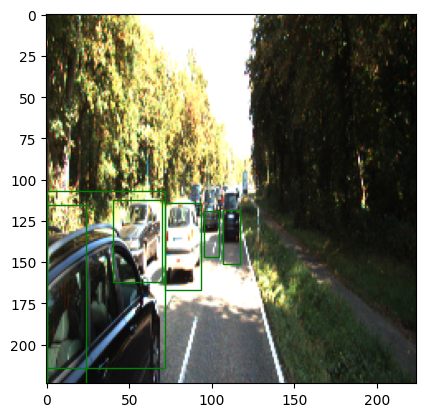

Epoch 1/5
 6/80 ━━━━━━━━━━━━━━━━━━━━ 5:00 4s/step - bbox_reshaped_mae: 0.4533 - loss: 1.6931 - orientation_reshaped_mae: 0.7907

KeyboardInterrupt: 

In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
import numpy as np

def preprocess_image(image, bbox, label, orientation, input_shape):
    # Filter out non-car objects (car: type = 0)
    car_indices = tf.where(label == 0)[:, 0]
    bbox = tf.gather(bbox, car_indices)
    label = tf.gather(label, car_indices)
    orientation = tf.gather(orientation, car_indices)
    
    # filter out images with more objects inside the image
    num_objects = tf.shape(bbox)[0]
    max_objects = 15
    # select max number of bboxes and orientation from the dataset
    bbox = tf.cond(num_objects <= max_objects,
                   lambda: bbox,
                   lambda: bbox[:max_objects])
    orientation = tf.cond(num_objects <= max_objects,
                          lambda: orientation,
                          lambda: orientation[:max_objects])
    
    image = tf.image.resize(image, (input_shape[0], input_shape[1]))
    image = image / 255.0 

    # Handling multiple objects in a single image
    # Pad bounding boxes and orientations to a fixed number (16)
    bbox = tf.pad(bbox, [[0, 16 - tf.shape(bbox)[0]], [0, 0]], constant_values=0)
    orientation = tf.pad(orientation, [[0, 16 - tf.shape(orientation)[0]], [0, 0]], constant_values=0)

    return image, (bbox, orientation)

def preprocess(example, input_shape):
    # access relevant information only
    image = example['image']
    bbox = example['objects']['bbox']
    label = example['objects']['type']
    orientation = example['objects']['dimensions']
    # Preprocess each image, bbox, label
    image, (bbox, orientation) = preprocess_image(image, bbox, label, orientation, input_shape)

    return image, (bbox, orientation)

def load_kitti_dataset(split, input_shape):
    # Load dataset
    dataset = tfds.load('kitti', split=split)

    # Apply preprocessing function to dataset
    dataset = dataset.map(lambda example: preprocess(example, input_shape))

    return dataset

def create_model(input_shape):
    # To be changed: pre - trained model; used ResNet for testing purpose
    # Load ResNet50 with pre-trained weights
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Use pre-trained weights and only change those of final layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom layers for object detection
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)

    # shapes??????  - might have to adapt the shapes below  
    # Output layers for bounding box regression and orientation prediction
    bbox_output = layers.Dense(16 * 4, name='bbox_output')(x)
    orientation_output = layers.Dense(16 * 3, name='orientation_output')(x)

    # Reshape the outputs
    bbox_output = layers.Reshape((16, 4), name="bbox_reshaped")(bbox_output)
    orientation_output = layers.Reshape((16, 3),name="orientation_reshaped")(orientation_output)

    # Define the model
    model = tf.keras.Model(inputs=base_model.input, outputs=[bbox_output, orientation_output])

    return model

def visualize_ground_truth(dataset):
    # Function to plot images with ground truth bounding boxes
    for image, (bbox_labels, orientation_labels) in dataset.take(1):
        # Plot image with ground truth bounding boxes
        plot_image_with_bbox(image[0], bbox_labels[0], orientation_labels[0])

def plot_image_with_bbox(image, bboxes, orientations):
    height, width, _ = image.shape
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for bbox in bboxes:
        if tf.reduce_all(tf.equal(bbox, 0)):
            continue
        left = bbox[1] * width
        top = bbox[0] * height
        right = bbox[3] * width
        bottom = bbox[2] * height
        rect = patches.Rectangle((left, bottom), right - left, bottom - top, linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

    plt.show()

def main():
    # Input image shape
    input_shape = (224, 224, 3)

    # Create and compile the model
    # change the metrics and losses - did not find average precision as metric from tensorflow
    model = create_model(input_shape)
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss={'bbox_reshaped': 'mean_squared_error', 'orientation_reshaped': 'mean_squared_error'},
                  metrics={'bbox_reshaped': 'mae', 'orientation_reshaped': 'mae'})

    # Load and preprocess dataset
    train_dataset = load_kitti_dataset('train[:80%]', input_shape)
    test_dataset = load_kitti_dataset('train[80%:]', input_shape)
    print(len(train_dataset))
    
    # Apply padding and batching
    train_dataset = train_dataset.padded_batch(64, padded_shapes=([224,224, 3], ([16, 4], [16, 3])))
    test_dataset = test_dataset.padded_batch(64, padded_shapes=([224,224, 3], ([16, 4], [16, 3])))

    visualize_ground_truth(test_dataset)
    
    # Train the model
    model.fit(train_dataset, epochs=5, validation_data=test_dataset)

if __name__ == "__main__":
    main()


Virtual KITTI Dataloader

In [11]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from PIL import Image


def read_and_preprocess_image(filename, input_shape):
    image = Image.open(filename)
    image = image.resize((input_shape[1], input_shape[0]))  # 1st width, 2nd height
    image = np.array(image) / 255.0  # normalize as above
    return image

def parse_bbox_data(bbox_lines):
    
    # obtain data from bbox.txt (2D bbox)
    frame_id = bbox_lines["frame"]

    l = bbox_lines["left"]
    r = bbox_lines["right"]
    t = bbox_lines["top"]
    b = bbox_lines["bottom"]  
    bbox_data = {
        'frame_id': frame_id,
        'left': l,
        'right': r,
        'top': t,
        'bottom': b
    }

    # Create DataFrame
    bbox_data = pd.DataFrame(bbox_data)

    print(bbox_data)
 
    return bbox_data

def parse_orientation_data(pose_lines):
    
    # obtain data from pose.txt (orientation)
    frame_id = pose_lines["frame"]
    print(frame_id)
    
    width = pose_lines["width"]
    height = pose_lines ["height"]
    length = pose_lines["length"] 
    pose_data = {
        'frame_id': frame_id,
        'width': width,
        'height': height,
        'length': length
    }
        
    return pose_data


def data_generator(grouped_data, input_shape):
    for filename, bboxes, orientations in grouped_data:
        image = read_and_preprocess_image(filename, input_shape)
        yield image, (bboxes.astype(np.int32), orientations.astype(np.float32))


def load_virtual_kitti_dataset(image_folder, bbox_file, pose_file, input_shape):
    image_filenames = sorted([os.path.join(image_folder, filename) for filename in os.listdir(image_folder) if filename.endswith('.jpg')])

    bbox = pd.read_csv(bbox_file, delim_whitespace=True, header=0)
    orientation = pd.read_csv(pose_file, delim_whitespace=True, header=0)

    bbox_data = parse_bbox_data(bbox)
    orientation_data = parse_orientation_data(orientation)

    # Use frame_id to group image, bbox, and orientation
    grouped_data = []
    for filename in image_filenames:
        frame_id = os.path.splitext(os.path.basename(filename))[0]
        bboxes = bbox_data[bbox_data['frame_id'] == frame_id][['left', 'right', 'top', 'bottom']].values
        orientations = orientation_data[orientation_data['frame_id'].isin([frame_id])][['width', 'height', 'length']].values
        grouped_data.append((filename, bboxes, orientations))

    # Create dataset from generator
    dataset = tf.data.Dataset.from_generator(lambda: data_generator(grouped_data, input_shape),
                                             output_signature=(tf.TensorSpec(shape=input_shape, dtype=tf.float32),
                                                               (tf.TensorSpec(shape=(None, 4), dtype=tf.int32),
                                                                tf.TensorSpec(shape=(None, 3), dtype=tf.float32))))
    return dataset

def main():

    image_folder = r'C:\Arbeitsordner\Abgaben_repo\vkitti_2.0.3_rgb\Scene01\15-deg-left\frames\rgb\Camera_0'
    bbox_file = r'C:\Arbeitsordner\Abgaben_repo\vkitti_2.0.3_textgt\Scene01\15-deg-left\bbox.txt'
    pose_file = r'C:\Arbeitsordner\Abgaben_repo\vkitti_2.0.3_textgt\Scene01\15-deg-left\pose.txt'

    input_shape = (224, 224, 3)



    dataset = load_virtual_kitti_dataset(image_folder, bbox_file, pose_file, input_shape)

    print("Dataset:", dataset)

    # troubleshooting
    for image, (bbox, pose) in dataset.take(1):
        print("Image shape:", image.shape)
        print("Bounding Box:", bbox.numpy())
        print("Pose:", pose.numpy())

if __name__ == "__main__":
    main()


       frame_id  left  right  top  bottom
0             0   988   1241  159     374
1             0   927   1102  171     275
2             0   897    984  171     236
3             0   591    666  187     239
4             0   699    732  181     206
...         ...   ...    ...  ...     ...
14239       423     0    416  203     374
14240       424     0    429  205     374
14241       424     0    385  205     374
14242       425     0    397  207     374
14243       425     0    349  207     374

[14244 rows x 5 columns]
0          0
1          0
2          0
3          0
4          0
        ... 
14239    423
14240    424
14241    424
14242    425
14243    425
Name: frame, Length: 14244, dtype: int64


TypeError: unhashable type: 'Series'